# Import libraries

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
from tqdm import tqdm

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

import gym

# Introduction to OpenAI gym

- In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

In [2]:
import gym
# gym.envs.registry.all()  # list all the available environments

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

## CartPole-v1
- 기둥은 작동되지 않는 조인트를 통해 마찰이 없는 트랙을 따라 움직이는 카트에 부착된다.
- 시스템은 카트에 +1 또는 -1의 힘을 적용하여 제어됩니다. 진자는 수직으로 시작하며, 목표는 진자가 넘어지는 것을 방지하는 것이다.
- 폴이 똑바로 유지되는 모든 시간 단계에 대해 +1의 보상이 제공됩니다.
- 극이 수직에서 15도 이상 기울거나 수레가 중심에서 2.4단위 이상 이동하면 에피소드가 종료된다.

- 데모 동영상: https://ichi.pro/ko/cartpole-ganghwa-hagseub-sogae-dqn-deep-q-learning-260647433896584

In [3]:
env = gym.make('CartPole-v1')
env.seed(42)
obs = env.reset()  # initialize, env returns an observation

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


- Observations:  1D NumPy array composed of 4 floats
  - 카트의 위치(**horizontal position**), 속도(**velocity**), 수직 각도(**angle**: 0 = vertical), 각속도(**angular velocity**)

- ranges: see https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L75

In [4]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [5]:
# set mode="rgb_array" to get an image of the environment as a NumPy array
img = env.render(mode="rgb_array")
img.shape

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


(400, 600, 3)

In [6]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

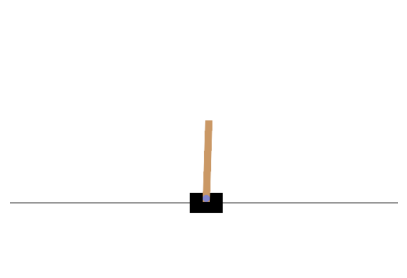

In [7]:
plot_environment(env)
plt.show()

- Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [ ]:
# help(env)

In [10]:
env.action_space, env.observation_space, env.observation_space.shape

(Discrete(2),
 Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 (4,))

- There are two possible actions: accelerate towards the left or towards the right.
Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [11]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs # [position of cart, velocity of cart, angle of pole, rotation rate of pole]

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

In [12]:
print(reward) # The environment also tells the agent how much reward it got during the last step
print(done)  # When the game is over, the environment returns done=True:
print(info)  # environment-specific dictionary that can provide some extra information

1.0
False
{}


- Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.


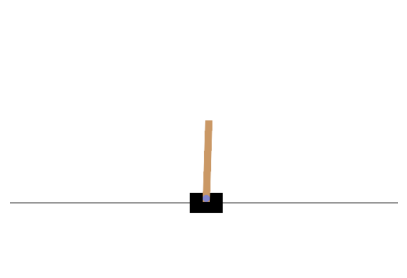

In [14]:
plot_environment(env)
plt.show()

- The sequence of steps between the moment the environment is reset until it is done is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True`), you should reset the environment before you continue to use it.

In [15]:
if done:
    obs = env.reset()

- Now how can we make the poll remain upright? We will need to define a **_policy_** for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

- Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [16]:
# A simple hard-coded policy

def basic_policy(obs):
    angle = obs[2]
    if angle < 0:
      action = 0     # move left
    else:
      action = 1     # move right
    return action

In [18]:
####
env = gym.make('CartPole-v1', new_step_api=True)
env.reset(seed=42)
action = 1
env.step(action)   # returns obs, reward, done, info, _

(array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32),
 1.0,
 False,
 False,
 {})

In [19]:
# main
env = gym.make('CartPole-v1', new_step_api=True)

totals = []
for episode in range(500):
  episode_rewards = 0
  obs = env.reset()

  for step in range(200):
    action = basic_policy(obs)   # obs is the state
    obs, reward, done, info, _ = env.step(action)
    episode_rewards += reward
    if done:
      break

  totals.append(episode_rewards)

In [20]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.508, 9.471321766258392, 24.0, 68.0)

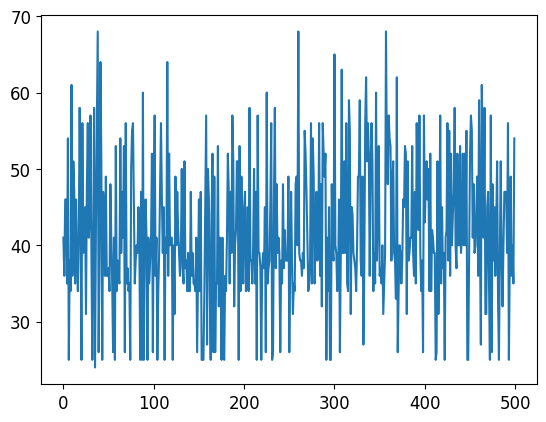

In [21]:
plt.plot(totals)

- As expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 68 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

### Putting all together

41.916 9.468946298295286 24.0 72.0


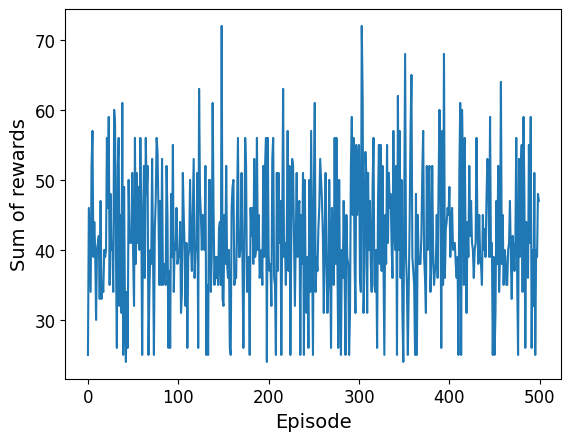

In [22]:
def basic_policy(obs):
    angle = obs[2]
    if angle < 0:
      action = 0     # move left
    else:
      action = 1     # move right
    return action

env = gym.make('CartPole-v1', new_step_api=True)

totals = []
for episode in range(500):
  episode_rewards = 0
  obs = env.reset()

  for step in range(200):
    action = basic_policy(obs)   # obs is the state
    obs, reward, done, info, _ = env.step(action)
    episode_rewards += reward
    if done:
      break

  totals.append(episode_rewards)

print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))
plt.plot(totals)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

- Let's visualize one episode:

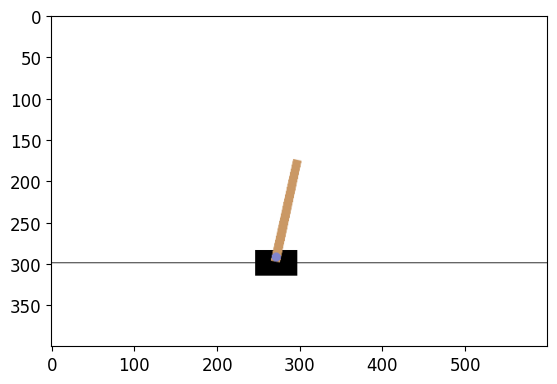

In [23]:
# env.render returns an image
img = env.render(mode="rgb_array")
plt.imshow(img)

- plot animation

In [24]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info, _ = env.step(action)
    # if done:
    #    break

/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Now show the animation:

In [29]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('on')
    anim = animation.FuncAnimation(fig,
                                   update_scene,
                                   fargs=(frames, patch),
                                   frames=len(frames),
                                   repeat=repeat,
                                   interval=interval)
    plt.close()
    return anim

In [26]:
np.shape(frames)

(200, 400, 600, 3)

In [30]:
plot_animation(frames)

Output hidden; open in https://colab.research.google.com to view.

- Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Randomly initialized Neural Network Policies

- Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation.
- To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities.
- In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: **it will output the probability `p` of the action 0 (left)**, and of course the probability of action 1 (right) will be `1 - p`.

* Basic Assumption
  - noise-free
  - the observation contains the full state of the environment

In [31]:
keras.backend.clear_session()    # Resets all state generated by Keras.
tf.random.set_seed(42)
np.random.seed(42)

# neural network policy

n_inputs = 4    # obs

model1 = keras.models.Sequential([
    keras.layers.Dense(5, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 25        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
# randomly initialized policy network

env = gym.make('CartPole-v1', new_step_api=True)

totals = []
for episode in range(500):
  episode_rewards = 0
  obs = env.reset()

  for step in range(200):
    left_proba = model1(obs.reshape(1,-1))
    action = int(np.random.rand() > left_proba)
    obs, reward, done, info, _ = env.step(action)
    episode_rewards += reward
    if done:
      break

  totals.append(episode_rewards)

In [33]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(19.044, 9.081963664318415, 8.0, 63.0)

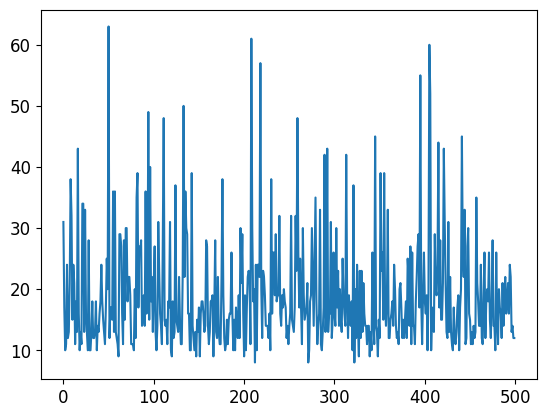

In [34]:
plt.plot(totals)

- pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

# Trained neural network
- We can make the same net play in 50 different environments in parallel (this will give us a diverse training batch at each step), and train for 5000 iterations.
- We also reset environments when they are done.
- We train the model using a custom training loop so we can easily use the predictions at each training step to advance the environments.

In [35]:
n_inputs = 4    # obs

model1 = keras.models.Sequential([
    keras.layers.Dense(5, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5)                 25        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
n_environments = 50
n_iterations = 1000

model2 = keras.models.clone_model(model1)

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]

for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)

observations = [env.reset() for env in envs]   # (50,4)
# optimizer = keras.optimizers.RMSprop()
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.binary_crossentropy

for iteration in tqdm(range(n_iterations)):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model2(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))

    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(grads, model2.trainable_variables))

    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32) # (50,1)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration: 0, Loss: 0.694

  1%|          | 9/1000 [00:01<01:55,  8.55it/s]

Iteration: 16, Loss: 0.709

  2%|▎         | 25/1000 [00:01<00:36, 26.40it/s]

Iteration: 32, Loss: 0.702

  4%|▍         | 41/1000 [00:01<00:21, 44.05it/s]

Iteration: 48, Loss: 0.703

  6%|▌         | 57/1000 [00:02<00:16, 57.70it/s]

Iteration: 64, Loss: 0.674

  7%|▋         | 73/1000 [00:02<00:14, 65.09it/s]

Iteration: 79, Loss: 0.696

  9%|▉         | 89/1000 [00:02<00:13, 69.63it/s]

Iteration: 95, Loss: 0.705

 10%|█         | 105/1000 [00:02<00:12, 72.64it/s]

Iteration: 111, Loss: 0.664

 12%|█▏        | 121/1000 [00:02<00:11, 73.40it/s]

Iteration: 126, Loss: 0.681

 14%|█▎        | 137/1000 [00:03<00:11, 72.01it/s]

Iteration: 141, Loss: 0.648

 15%|█▌        | 153/1000 [00:03<00:11, 73.69it/s]

Iteration: 157, Loss: 0.676

 17%|█▋        | 169/1000 [00:03<00:11, 73.08it/s]

Iteration: 172, Loss: 0.679

 18%|█▊        | 185/1000 [00:03<00:11, 70.97it/s]

Iteration: 186, Loss: 0.638

 20%|██        | 201/1000 [00:03<00:11, 72.46it/s]

Iteration: 201, Loss: 0.585

 21%|██        | 209/1000 [00:04<00:11, 71.70it/s]

Iteration: 216, Loss: 0.610

 22%|██▎       | 225/1000 [00:04<00:10, 71.14it/s]

Iteration: 231, Loss: 0.602

 24%|██▍       | 241/1000 [00:04<00:10, 73.78it/s]

Iteration: 247, Loss: 0.649

 26%|██▌       | 257/1000 [00:04<00:10, 73.45it/s]

Iteration: 262, Loss: 0.611

 27%|██▋       | 273/1000 [00:04<00:09, 73.84it/s]

Iteration: 278, Loss: 0.613

 29%|██▉       | 289/1000 [00:05<00:09, 73.57it/s]

Iteration: 293, Loss: 0.603

 30%|███       | 305/1000 [00:05<00:09, 72.81it/s]

Iteration: 308, Loss: 0.624

 32%|███▏      | 321/1000 [00:05<00:09, 73.23it/s]

Iteration: 323, Loss: 0.604

 34%|███▎      | 337/1000 [00:05<00:09, 71.11it/s]

Iteration: 337, Loss: 0.589

 35%|███▌      | 353/1000 [00:06<00:08, 72.12it/s]

Iteration: 352, Loss: 0.600

 36%|███▌      | 361/1000 [00:06<00:09, 70.26it/s]

Iteration: 367, Loss: 0.595

 38%|███▊      | 377/1000 [00:06<00:08, 73.13it/s]

Iteration: 383, Loss: 0.624

 39%|███▉      | 393/1000 [00:06<00:08, 74.74it/s]

Iteration: 399, Loss: 0.641

 41%|████      | 409/1000 [00:06<00:07, 75.88it/s]

Iteration: 415, Loss: 0.660

 42%|████▎     | 425/1000 [00:07<00:07, 76.05it/s]

Iteration: 431, Loss: 0.630

 44%|████▍     | 441/1000 [00:07<00:07, 76.46it/s]

Iteration: 447, Loss: 0.574

 46%|████▌     | 457/1000 [00:07<00:07, 74.61it/s]

Iteration: 462, Loss: 0.610

 47%|████▋     | 473/1000 [00:07<00:07, 72.96it/s]

Iteration: 477, Loss: 0.591

 49%|████▉     | 489/1000 [00:07<00:07, 72.74it/s]

Iteration: 492, Loss: 0.583

 50%|█████     | 505/1000 [00:08<00:06, 70.74it/s]

Iteration: 506, Loss: 0.600

 52%|█████▏    | 521/1000 [00:08<00:06, 69.78it/s]

Iteration: 520, Loss: 0.604

 53%|█████▎    | 528/1000 [00:08<00:06, 68.64it/s]

Iteration: 534, Loss: 0.575

 54%|█████▍    | 544/1000 [00:08<00:06, 71.63it/s]

Iteration: 550, Loss: 0.587

 56%|█████▌    | 560/1000 [00:08<00:05, 74.08it/s]

Iteration: 566, Loss: 0.559

 58%|█████▊    | 576/1000 [00:09<00:05, 73.86it/s]

Iteration: 581, Loss: 0.590

 59%|█████▉    | 592/1000 [00:09<00:05, 73.07it/s]

Iteration: 596, Loss: 0.584

 61%|██████    | 608/1000 [00:09<00:05, 71.65it/s]

Iteration: 611, Loss: 0.530

 62%|██████▏   | 624/1000 [00:09<00:05, 71.14it/s]

Iteration: 626, Loss: 0.559

 64%|██████▍   | 640/1000 [00:10<00:04, 72.51it/s]

Iteration: 641, Loss: 0.535

 66%|██████▌   | 656/1000 [00:10<00:04, 73.24it/s]

Iteration: 656, Loss: 0.541

 66%|██████▋   | 664/1000 [00:10<00:04, 73.28it/s]

Iteration: 671, Loss: 0.530

 68%|██████▊   | 680/1000 [00:10<00:04, 70.82it/s]

Iteration: 686, Loss: 0.556

 70%|██████▉   | 696/1000 [00:10<00:04, 70.99it/s]

Iteration: 701, Loss: 0.592

 71%|███████   | 712/1000 [00:11<00:03, 72.71it/s]

Iteration: 717, Loss: 0.535

 73%|███████▎  | 728/1000 [00:11<00:03, 71.66it/s]

Iteration: 731, Loss: 0.517

 74%|███████▍  | 744/1000 [00:11<00:03, 71.40it/s]

Iteration: 746, Loss: 0.519

 76%|███████▌  | 760/1000 [00:11<00:03, 71.78it/s]

Iteration: 761, Loss: 0.538

 78%|███████▊  | 776/1000 [00:11<00:03, 72.69it/s]

Iteration: 776, Loss: 0.555

 78%|███████▊  | 784/1000 [00:12<00:02, 72.17it/s]

Iteration: 791, Loss: 0.559

 80%|████████  | 800/1000 [00:12<00:02, 72.56it/s]

Iteration: 807, Loss: 0.521

 82%|████████▏ | 816/1000 [00:12<00:02, 74.47it/s]

Iteration: 823, Loss: 0.597

 83%|████████▎ | 832/1000 [00:12<00:02, 75.15it/s]

Iteration: 839, Loss: 0.485

 86%|████████▌ | 856/1000 [00:12<00:01, 77.19it/s]

Iteration: 855, Loss: 0.565

 86%|████████▋ | 864/1000 [00:13<00:01, 76.98it/s]

Iteration: 871, Loss: 0.557

 88%|████████▊ | 880/1000 [00:13<00:01, 75.88it/s]

Iteration: 887, Loss: 0.567

 90%|████████▉ | 896/1000 [00:13<00:01, 75.76it/s]

Iteration: 903, Loss: 0.535

 92%|█████████▏| 920/1000 [00:13<00:01, 76.78it/s]

Iteration: 919, Loss: 0.532

 93%|█████████▎| 928/1000 [00:13<00:00, 76.54it/s]

Iteration: 935, Loss: 0.466

 94%|█████████▍| 944/1000 [00:14<00:00, 74.48it/s]

Iteration: 951, Loss: 0.520

 96%|█████████▌| 960/1000 [00:14<00:00, 74.30it/s]

Iteration: 966, Loss: 0.472

 98%|█████████▊| 976/1000 [00:14<00:00, 73.52it/s]

Iteration: 982, Loss: 0.491

 99%|█████████▉| 992/1000 [00:14<00:00, 74.16it/s]

Iteration: 998, Loss: 0.474

100%|██████████| 1000/1000 [00:14<00:00, 67.10it/s]

Iteration: 999, Loss: 0.451

In [37]:
actions.shape

(50, 1)

In [38]:
obs = np.array([[0.1, 2.0, 1.1, 0.4]])
model2(obs), model2.predict(obs)

1/1 [==============================] - 0s 95ms/step


(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.3547903]], dtype=float32)>,
 array([[0.3547903]], dtype=float32))

In [ ]:
# model1.weights, model2.weights

In [40]:
# trained with a simple strategy (if angle<0, move left, else move right)
# main
env = gym.make('CartPole-v1', new_step_api=True)

totals = []
for episode in tqdm(range(500)):
  episode_rewards = 0
  obs = env.reset()

  for step in range(200):
    left_proba = model2(obs.reshape(1,-1))
    action = int(np.random.rand() > left_proba)  # uniform random number in [0,1)
    obs, reward, done, info, _ = env.step(action)
    episode_rewards += reward
    if done:
      break

  totals.append(episode_rewards)

100%|██████████| 500/500 [01:03<00:00,  7.83it/s]


59.786 34.35223724883141 11.0 200.0


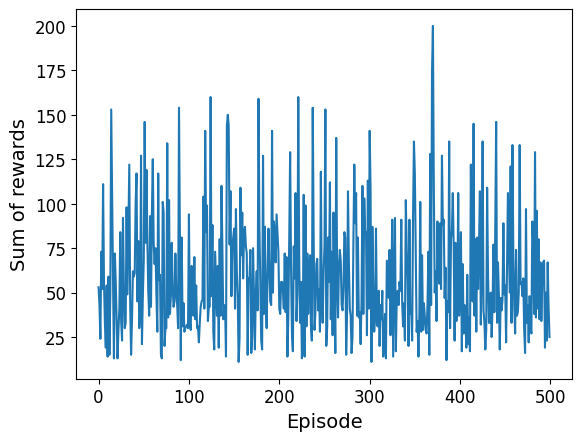

In [41]:
print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))
plt.plot(totals)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

Looks like it learned the policy correctly. Now let's see if it can learn a better policy on its own. One that does not wobble as much.

## Putting all together

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration: 0, Loss: 0.698

  1%|          | 8/1000 [00:00<00:36, 27.55it/s]

Iteration: 14, Loss: 0.843

  3%|▎         | 29/1000 [00:00<00:17, 55.78it/s]

Iteration: 28, Loss: 0.825

  4%|▍         | 43/1000 [00:00<00:15, 61.84it/s]

Iteration: 42, Loss: 0.760

  6%|▌         | 57/1000 [00:01<00:14, 64.81it/s]

Iteration: 56, Loss: 0.772

  7%|▋         | 71/1000 [00:01<00:13, 67.18it/s]

Iteration: 71, Loss: 0.754

  8%|▊         | 85/1000 [00:01<00:13, 66.89it/s]

Iteration: 85, Loss: 0.706

 10%|█         | 100/1000 [00:01<00:12, 69.65it/s]

Iteration: 100, Loss: 0.702

 12%|█▏        | 116/1000 [00:01<00:12, 71.89it/s]

Iteration: 115, Loss: 0.693

 12%|█▏        | 124/1000 [00:02<00:12, 70.99it/s]

Iteration: 130, Loss: 0.664

 14%|█▍        | 140/1000 [00:02<00:12, 70.26it/s]

Iteration: 145, Loss: 0.687

 16%|█▌        | 155/1000 [00:02<00:12, 68.95it/s]

Iteration: 159, Loss: 0.670

 17%|█▋        | 169/1000 [00:02<00:12, 67.85it/s]

Iteration: 173, Loss: 0.654

 18%|█▊        | 183/1000 [00:02<00:11, 68.25it/s]

Iteration: 187, Loss: 0.632

 20%|█▉        | 198/1000 [00:03<00:11, 68.68it/s]

Iteration: 202, Loss: 0.665

 21%|██▏       | 214/1000 [00:03<00:11, 70.24it/s]

Iteration: 217, Loss: 0.638

 23%|██▎       | 229/1000 [00:03<00:11, 69.50it/s]

Iteration: 231, Loss: 0.623

 24%|██▍       | 244/1000 [00:03<00:10, 70.52it/s]

Iteration: 246, Loss: 0.619

 26%|██▌       | 260/1000 [00:03<00:10, 70.11it/s]

Iteration: 261, Loss: 0.644

 28%|██▊       | 275/1000 [00:04<00:10, 69.00it/s]

Iteration: 275, Loss: 0.672

 29%|██▉       | 289/1000 [00:04<00:10, 68.98it/s]

Iteration: 290, Loss: 0.655

 30%|███       | 303/1000 [00:04<00:10, 68.83it/s]

Iteration: 304, Loss: 0.598

 32%|███▏      | 317/1000 [00:04<00:10, 68.26it/s]

Iteration: 318, Loss: 0.652

 33%|███▎      | 332/1000 [00:05<00:09, 69.30it/s]

Iteration: 333, Loss: 0.645

 35%|███▍      | 346/1000 [00:05<00:09, 68.39it/s]

Iteration: 347, Loss: 0.623

 36%|███▌      | 360/1000 [00:05<00:09, 68.62it/s]

Iteration: 361, Loss: 0.624

 38%|███▊      | 375/1000 [00:05<00:09, 68.94it/s]

Iteration: 376, Loss: 0.613

 39%|███▉      | 389/1000 [00:05<00:08, 68.71it/s]

Iteration: 390, Loss: 0.614

 40%|████      | 404/1000 [00:06<00:08, 69.21it/s]

Iteration: 405, Loss: 0.634

 42%|████▏     | 418/1000 [00:06<00:08, 69.19it/s]

Iteration: 420, Loss: 0.631

 43%|████▎     | 432/1000 [00:06<00:08, 68.42it/s]

Iteration: 434, Loss: 0.557

 45%|████▍     | 446/1000 [00:06<00:08, 68.68it/s]

Iteration: 449, Loss: 0.549

 46%|████▌     | 462/1000 [00:06<00:07, 70.36it/s]

Iteration: 464, Loss: 0.632

 48%|████▊     | 478/1000 [00:07<00:07, 70.59it/s]

Iteration: 479, Loss: 0.514

 49%|████▉     | 494/1000 [00:07<00:07, 70.57it/s]

Iteration: 494, Loss: 0.614

 51%|█████     | 509/1000 [00:07<00:07, 69.46it/s]

Iteration: 508, Loss: 0.640

 52%|█████▏    | 523/1000 [00:07<00:06, 69.26it/s]

Iteration: 522, Loss: 0.575

 53%|█████▎    | 530/1000 [00:07<00:06, 68.83it/s]

Iteration: 537, Loss: 0.600

 55%|█████▍    | 546/1000 [00:08<00:06, 70.54it/s]

Iteration: 552, Loss: 0.613

 56%|█████▌    | 562/1000 [00:08<00:06, 71.39it/s]

Iteration: 567, Loss: 0.639

 58%|█████▊    | 578/1000 [00:08<00:05, 70.62it/s]

Iteration: 582, Loss: 0.659

 59%|█████▉    | 594/1000 [00:08<00:05, 70.76it/s]

Iteration: 597, Loss: 0.627

 61%|██████    | 610/1000 [00:09<00:05, 71.42it/s]

Iteration: 612, Loss: 0.582

 63%|██████▎   | 626/1000 [00:09<00:05, 70.69it/s]

Iteration: 627, Loss: 0.540

 64%|██████▍   | 642/1000 [00:09<00:05, 71.28it/s]

Iteration: 642, Loss: 0.588

 65%|██████▌   | 650/1000 [00:09<00:04, 70.80it/s]

Iteration: 656, Loss: 0.561

 67%|██████▋   | 666/1000 [00:09<00:04, 69.48it/s]

Iteration: 670, Loss: 0.498

 68%|██████▊   | 681/1000 [00:10<00:04, 69.55it/s]

Iteration: 685, Loss: 0.560

 70%|██████▉   | 696/1000 [00:10<00:04, 69.37it/s]

Iteration: 700, Loss: 0.547

 71%|███████   | 710/1000 [00:10<00:04, 68.27it/s]

Iteration: 714, Loss: 0.551

 72%|███████▏  | 724/1000 [00:10<00:04, 68.31it/s]

Iteration: 729, Loss: 0.545

 74%|███████▍  | 740/1000 [00:10<00:03, 69.55it/s]

Iteration: 744, Loss: 0.562

 76%|███████▌  | 755/1000 [00:11<00:03, 69.63it/s]

Iteration: 759, Loss: 0.495

 77%|███████▋  | 769/1000 [00:11<00:03, 69.11it/s]

Iteration: 774, Loss: 0.498

 78%|███████▊  | 784/1000 [00:11<00:03, 69.11it/s]

Iteration: 789, Loss: 0.539

 80%|███████▉  | 799/1000 [00:11<00:02, 68.12it/s]

Iteration: 803, Loss: 0.492

 81%|████████▏ | 814/1000 [00:11<00:02, 69.03it/s]

Iteration: 818, Loss: 0.564

 83%|████████▎ | 828/1000 [00:12<00:02, 69.17it/s]

Iteration: 832, Loss: 0.512

 84%|████████▍ | 842/1000 [00:12<00:02, 68.01it/s]

Iteration: 846, Loss: 0.513

 86%|████████▌ | 856/1000 [00:12<00:02, 68.07it/s]

Iteration: 860, Loss: 0.502

 87%|████████▋ | 870/1000 [00:12<00:01, 68.40it/s]

Iteration: 874, Loss: 0.489

 88%|████████▊ | 884/1000 [00:13<00:01, 67.20it/s]

Iteration: 888, Loss: 0.511

 90%|████████▉ | 898/1000 [00:13<00:01, 67.88it/s]

Iteration: 902, Loss: 0.511

 91%|█████████▏| 913/1000 [00:13<00:01, 68.76it/s]

Iteration: 917, Loss: 0.510

 93%|█████████▎| 928/1000 [00:13<00:01, 69.36it/s]

Iteration: 931, Loss: 0.497

 94%|█████████▍| 942/1000 [00:13<00:00, 68.57it/s]

Iteration: 945, Loss: 0.506

 96%|█████████▌| 956/1000 [00:14<00:00, 68.68it/s]

Iteration: 959, Loss: 0.450

 97%|█████████▋| 970/1000 [00:14<00:00, 68.40it/s]

Iteration: 973, Loss: 0.540

 98%|█████████▊| 985/1000 [00:14<00:00, 69.18it/s]

Iteration: 988, Loss: 0.510

100%|██████████| 1000/1000 [00:14<00:00, 68.01it/s]

Iteration: 999, Loss: 0.451

62.764 35.924814599382415 9.0 200.0


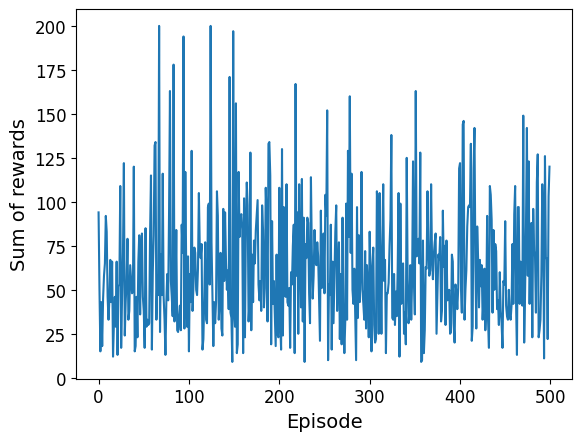

In [ ]:
n_inputs = 4    # obs

model1 = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

n_environments = 50
n_iterations = 1000

model2 = keras.models.clone_model(model1)

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]

for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)

observations = [env.reset() for env in envs]   # (50,4)
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in tqdm(range(n_iterations)):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model2(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(grads, model2.trainable_variables))

    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32) # (50,1)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

# main

env = gym.make('CartPole-v1', new_step_api=True)

totals = []
for episode in range(500):
  episode_rewards = 0
  obs = env.reset()

  for step in range(200):
    left_proba = model2(obs.reshape(1,-1))
    action = int(np.random.rand() > left_proba)  # uniform random number in [0,1)
    obs, reward, done, info, _ = env.step(action)
    episode_rewards += reward
    if done:
      break

  totals.append(episode_rewards)

print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))
plt.plot(totals)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

# Policy Gradient
- 먼저 여러 에피소드를 재생한 다음 좋은 에피소드의 동작 가능성을 약간 높이고 나쁜 에피소드의 동작 가능성을 약간 낮춤으로써 이 문제를 해결한다.

 Policy-gradient methods:
- In reinforcement learning, the term "trial and error" refers to the iterative process where an agent interacts with an environment, takes actions, receives feedback, and learns from its experiences to improve its performance over time. - Both value-based methods (like Q-learning and SARSA) and policy-based methods (like policy gradients) are forms of reinforcement learning, but they approach this process in different ways.
  - Value-Based Methods (e.g., Q-Learning, SARSA): In value-based methods, the agent learns to estimate the value of different actions or state-action pairs. It does this by updating its value estimates based on the rewards received and the expected future rewards according to the value function.
    - There's no explicit "trial and error" in the sense of directly adjusting the policy. Instead, the agent refines its value estimates through exploration and exploitation.
    - These methods aim to find the optimal value function, which can then be used to derive an optimal policy.
  - Policy-Based Methods (e.g., REINFORCE):
    - Policy-based methods, on the other hand, directly parameterize the policy and adjust its parameters to maximize expected return. This is done by explicitly seeking to increase the likelihood of actions that lead to higher returns.
    - The "trial and error" aspect is more explicit in policy-based methods, as the agent directly adjusts its policy and observes the consequences in terms of rewards.
    - These methods aim to find the optimal policy directly.
  - So, in a sense, policy-based methods like REINFORCE may have a more direct and interpretable "trial and error" component because they focus on directly optimizing the policy. This can make them well-suited for environments with complex action spaces and stochastic policies.
  - The policy gradient methods are more powerful than value-based methods, but they can also be more difficult to train (may not converge and/or takes more time to train)

In [ ]:
model3 = keras.models.clone_model(model1)

In [ ]:
def play_one_step(obs, model, loss_fn):

    with tf.GradientTape() as tape:
        left_proba = model3(obs.reshape(1,-1))
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32) # prob(left_move)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action))

    return obs, reward, done, grads

- y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32): This subtracts the action (cast as a float) from 1.0. This essentially means that if action is 0 (left), y_target will be 1.0 - 0.0 = 1.0, and if action is 1 (right), y_target will be 1.0 - 1.0 = 0.0.
- So, y_target is constructed to be 1.0 if the chosen action is 0 (left) and 0.0 if the chosen action is 1 (right). This target is then used in the loss function to compute the gradient during backpropagation.
- The idea is to encourage the policy network to increase the probability of selecting the chosen action in the future. This is a common approach in policy gradient methods like REINFORCE.
  - if the target is 1 and the chosen action was 0, it means that the model made a non-optimal (suboptimal) choice. This situation arises when the model selects an action that has a lower probability according to its current policy.
  - By using this information during training, the model's parameters are updated in a way that encourages it to increase the probability of selecting the action that leads to a higher target value in the future. This is a fundamental concept in reinforcement learning, particularly in policy gradient methods like REINFORCE.)

- 선택한 action 이 좋은 선택이라고 가정한다면 이 선택을 최대한 높여 줄 수 있는 확률을 y_target 으로 선정하고자 함.
- 즉, action=0 으로 선택했다면 이 선택을 최대로 할 수 있는 것은 y_target=1 로 되게 하는 것이다. (y_target=1 이라는 것은 모든 선택이 action=0 으로 되게 하는 것이기 때문임. y_target 은 left move (action=0) 에 대한 확률임을 생각하면 된다)
- 마찬가지로, action=1 으로 선택했다면 이 선택을 최선으로 하기 위해선 y_target=0 으로 하면 된다.

In [42]:
# play multiple episodes
# - returns all the rewards and gradients, for each episode and each step

def play_multiple_episodes(n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

- The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them.
- So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [ ]:
###
list(range(7,-1,-1))

[7, 6, 5, 4, 3, 2, 1, 0]

In [ ]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

- now run the algorithm

In [ ]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

env = gym.make("CartPole-v1")
env.seed(42);

for iteration in tqdm(range(n_iterations)):

    all_rewards, all_grads = play_multiple_episodes(
        n_episodes_per_update, n_max_steps, model3, loss_fn)
    total_rewards = sum(map(sum, all_rewards))
    print("\rIteration: {}, mean rewards: {:.1f}".format(
        iteration, total_rewards / n_episodes_per_update), end="")
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model3.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model3.trainable_variables))

env.close()

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration: 0, mean rewards: 12.5

  1%|▏         | 2/150 [00:02<03:11,  1.29s/it]

Iteration: 1, mean rewards: 12.7

  2%|▏         | 3/150 [00:03<02:50,  1.16s/it]

Iteration: 2, mean rewards: 11.7

  3%|▎         | 4/150 [00:04<02:45,  1.13s/it]

Iteration: 3, mean rewards: 12.9

  3%|▎         | 5/150 [00:05<02:42,  1.12s/it]

Iteration: 4, mean rewards: 12.2

  4%|▍         | 6/150 [00:07<02:45,  1.15s/it]

Iteration: 5, mean rewards: 14.3

  5%|▍         | 7/150 [00:08<02:51,  1.20s/it]

Iteration: 6, mean rewards: 14.9

  5%|▌         | 8/150 [00:09<03:02,  1.28s/it]

Iteration: 7, mean rewards: 17.2

  6%|▌         | 9/150 [00:11<02:59,  1.27s/it]

Iteration: 8, mean rewards: 14.7

  7%|▋         | 10/150 [00:12<02:58,  1.28s/it]

Iteration: 9, mean rewards: 15.1

  7%|▋         | 11/150 [00:13<03:09,  1.36s/it]

Iteration: 10, mean rewards: 18.5

  8%|▊         | 12/150 [00:15<03:08,  1.37s/it]

Iteration: 11, mean rewards: 16.6

  9%|▊         | 13/150 [00:16<03:13,  1.41s/it]

Iteration: 12, mean rewards: 18.0

  9%|▉         | 14/150 [00:18<03:14,  1.43s/it]

Iteration: 13, mean rewards: 17.6

 10%|█         | 15/150 [00:19<03:18,  1.47s/it]

Iteration: 14, mean rewards: 18.1

 11%|█         | 16/150 [00:21<03:27,  1.55s/it]

Iteration: 15, mean rewards: 20.0

 11%|█▏        | 17/150 [00:23<03:29,  1.57s/it]

Iteration: 16, mean rewards: 19.7

 12%|█▏        | 18/150 [00:24<03:22,  1.54s/it]

Iteration: 17, mean rewards: 17.6

 13%|█▎        | 19/150 [00:26<03:41,  1.69s/it]

Iteration: 18, mean rewards: 24.2

 13%|█▎        | 20/150 [00:28<03:35,  1.66s/it]

Iteration: 19, mean rewards: 19.2

 14%|█▍        | 21/150 [00:30<03:53,  1.81s/it]

Iteration: 20, mean rewards: 26.2

 15%|█▍        | 22/150 [00:32<04:08,  1.94s/it]

Iteration: 21, mean rewards: 26.5

 15%|█▌        | 23/150 [00:34<03:55,  1.86s/it]

Iteration: 22, mean rewards: 19.5

 16%|█▌        | 24/150 [00:37<04:40,  2.23s/it]

Iteration: 23, mean rewards: 37.6

 17%|█▋        | 25/150 [00:39<04:33,  2.19s/it]

Iteration: 24, mean rewards: 24.9

 17%|█▋        | 26/150 [00:41<04:34,  2.22s/it]

Iteration: 25, mean rewards: 27.5

 18%|█▊        | 27/150 [00:44<04:37,  2.25s/it]

Iteration: 26, mean rewards: 28.0

 19%|█▊        | 28/150 [00:46<04:20,  2.14s/it]

Iteration: 27, mean rewards: 22.2

 19%|█▉        | 29/150 [00:49<05:00,  2.48s/it]

Iteration: 28, mean rewards: 39.8

 20%|██        | 30/150 [00:52<05:13,  2.61s/it]

Iteration: 29, mean rewards: 35.8

 21%|██        | 31/150 [00:55<05:45,  2.91s/it]

Iteration: 30, mean rewards: 43.9

 21%|██▏       | 32/150 [00:58<05:16,  2.68s/it]

Iteration: 31, mean rewards: 26.2

 22%|██▏       | 33/150 [01:00<04:55,  2.53s/it]

Iteration: 32, mean rewards: 25.6

 23%|██▎       | 34/150 [01:03<05:15,  2.72s/it]

Iteration: 33, mean rewards: 37.9

 23%|██▎       | 35/150 [01:05<05:09,  2.69s/it]

Iteration: 34, mean rewards: 31.9

 24%|██▍       | 36/150 [01:09<05:20,  2.81s/it]

Iteration: 35, mean rewards: 36.3

 25%|██▍       | 37/150 [01:12<05:49,  3.09s/it]

Iteration: 36, mean rewards: 43.6

 25%|██▌       | 38/150 [01:16<06:08,  3.29s/it]

Iteration: 37, mean rewards: 46.2

 26%|██▌       | 39/150 [01:19<06:04,  3.28s/it]

Iteration: 38, mean rewards: 38.8

 27%|██▋       | 40/150 [01:22<05:48,  3.16s/it]

Iteration: 39, mean rewards: 33.6

 27%|██▋       | 41/150 [01:26<06:05,  3.35s/it]

Iteration: 40, mean rewards: 46.2

 28%|██▊       | 42/150 [01:30<06:19,  3.52s/it]

Iteration: 41, mean rewards: 48.5

 29%|██▊       | 43/150 [01:34<06:32,  3.67s/it]

Iteration: 42, mean rewards: 48.5

 29%|██▉       | 44/150 [01:37<06:22,  3.61s/it]

Iteration: 43, mean rewards: 41.5

 30%|███       | 45/150 [01:41<06:28,  3.70s/it]

Iteration: 45, mean rewards: 51.5

 31%|███       | 46/150 [01:46<06:42,  3.87s/it]

Iteration: 46, mean rewards: 49.1

 32%|███▏      | 48/150 [01:54<06:41,  3.94s/it]

Iteration: 48, mean rewards: 57.3

 33%|███▎      | 49/150 [01:58<07:04,  4.20s/it]

Iteration: 49, mean rewards: 50.1

 33%|███▎      | 50/150 [02:03<07:02,  4.23s/it]

Iteration: 50, mean rewards: 60.4

 35%|███▍      | 52/150 [02:11<06:54,  4.23s/it]

Iteration: 52, mean rewards: 58.8

 35%|███▌      | 53/150 [02:16<07:05,  4.39s/it]

Iteration: 53, mean rewards: 50.4

 36%|███▌      | 54/150 [02:20<06:55,  4.33s/it]

Iteration: 54, mean rewards: 56.5

 37%|███▋      | 55/150 [02:25<06:59,  4.41s/it]

Iteration: 55, mean rewards: 61.1

 37%|███▋      | 56/150 [02:30<07:09,  4.57s/it]

Iteration: 56, mean rewards: 68.0

 39%|███▊      | 58/150 [02:40<07:10,  4.68s/it]

Iteration: 58, mean rewards: 74.4

 39%|███▉      | 59/150 [02:46<07:49,  5.16s/it]

Iteration: 59, mean rewards: 70.0

 40%|████      | 60/150 [02:52<08:02,  5.36s/it]

Iteration: 60, mean rewards: 69.4

 41%|████      | 61/150 [02:58<08:05,  5.46s/it]

Iteration: 61, mean rewards: 60.4

 41%|████▏     | 62/150 [03:03<07:47,  5.31s/it]

Iteration: 62, mean rewards: 61.4

 42%|████▏     | 63/150 [03:08<07:35,  5.24s/it]

Iteration: 63, mean rewards: 67.0

 43%|████▎     | 64/150 [03:13<07:37,  5.32s/it]

Iteration: 64, mean rewards: 50.8

 43%|████▎     | 65/150 [03:17<07:02,  4.97s/it]

Iteration: 65, mean rewards: 51.1

 44%|████▍     | 66/150 [03:21<06:37,  4.73s/it]

Iteration: 66, mean rewards: 79.1

 45%|████▍     | 67/150 [03:28<07:17,  5.27s/it]

Iteration: 67, mean rewards: 67.2

 45%|████▌     | 68/150 [03:33<07:17,  5.34s/it]

Iteration: 68, mean rewards: 61.7

 46%|████▌     | 69/150 [03:39<07:07,  5.27s/it]

Iteration: 69, mean rewards: 62.4

 47%|████▋     | 70/150 [03:44<07:01,  5.27s/it]

Iteration: 70, mean rewards: 71.5

 47%|████▋     | 71/150 [03:50<07:12,  5.47s/it]

Iteration: 71, mean rewards: 73.2

 48%|████▊     | 72/150 [03:56<07:19,  5.64s/it]

Iteration: 72, mean rewards: 78.3

 49%|████▊     | 73/150 [04:02<07:36,  5.93s/it]

Iteration: 73, mean rewards: 65.4

 49%|████▉     | 74/150 [04:08<07:20,  5.79s/it]

Iteration: 74, mean rewards: 116.5

 50%|█████     | 75/150 [04:17<08:39,  6.92s/it]

Iteration: 75, mean rewards: 96.7

 51%|█████     | 76/150 [04:25<08:50,  7.17s/it]

Iteration: 76, mean rewards: 96.3

 51%|█████▏    | 77/150 [04:33<08:57,  7.37s/it]

Iteration: 77, mean rewards: 114.3

 52%|█████▏    | 78/150 [04:42<09:30,  7.92s/it]

Iteration: 78, mean rewards: 82.7

 53%|█████▎    | 79/150 [04:49<08:53,  7.52s/it]

Iteration: 79, mean rewards: 110.2

 53%|█████▎    | 80/150 [04:58<09:16,  7.95s/it]

Iteration: 80, mean rewards: 133.4

 54%|█████▍    | 81/150 [05:08<10:05,  8.78s/it]

Iteration: 81, mean rewards: 96.6

 55%|█████▍    | 82/150 [05:16<09:35,  8.46s/it]

Iteration: 82, mean rewards: 112.7

 55%|█████▌    | 83/150 [05:25<09:34,  8.58s/it]

Iteration: 83, mean rewards: 136.8

 56%|█████▌    | 84/150 [05:36<10:16,  9.34s/it]

Iteration: 84, mean rewards: 87.1

 57%|█████▋    | 85/150 [05:43<09:23,  8.66s/it]

Iteration: 85, mean rewards: 127.1

 57%|█████▋    | 86/150 [05:54<09:46,  9.16s/it]

Iteration: 86, mean rewards: 113.2

 58%|█████▊    | 87/150 [06:03<09:34,  9.11s/it]

Iteration: 87, mean rewards: 166.9

 59%|█████▊    | 88/150 [06:16<10:44, 10.40s/it]

Iteration: 88, mean rewards: 121.9

 59%|█████▉    | 89/150 [06:26<10:24, 10.23s/it]

Iteration: 89, mean rewards: 131.2

 60%|██████    | 90/150 [06:36<10:19, 10.33s/it]

Iteration: 90, mean rewards: 174.2

 61%|██████    | 91/150 [06:50<11:12, 11.39s/it]

Iteration: 91, mean rewards: 179.4

 61%|██████▏   | 92/150 [07:05<11:51, 12.26s/it]

Iteration: 92, mean rewards: 167.7

 62%|██████▏   | 93/150 [07:18<12:00, 12.64s/it]

Iteration: 93, mean rewards: 137.7

 63%|██████▎   | 94/150 [07:29<11:19, 12.13s/it]

Iteration: 94, mean rewards: 132.6

 63%|██████▎   | 95/150 [07:40<10:42, 11.69s/it]

Iteration: 95, mean rewards: 179.9

 64%|██████▍   | 96/150 [07:54<11:14, 12.49s/it]

Iteration: 96, mean rewards: 128.7

 65%|██████▍   | 97/150 [08:04<10:28, 11.86s/it]

Iteration: 97, mean rewards: 147.0

 65%|██████▌   | 98/150 [08:16<10:13, 11.80s/it]

Iteration: 98, mean rewards: 143.9

 66%|██████▌   | 99/150 [08:28<09:56, 11.70s/it]

Iteration: 99, mean rewards: 121.5

 67%|██████▋   | 100/150 [08:37<09:18, 11.16s/it]

Iteration: 100, mean rewards: 137.5

 67%|██████▋   | 101/150 [08:49<09:10, 11.24s/it]

Iteration: 101, mean rewards: 165.8

 68%|██████▊   | 102/150 [09:02<09:30, 11.89s/it]

Iteration: 102, mean rewards: 130.0

 69%|██████▊   | 103/150 [09:13<08:56, 11.42s/it]

Iteration: 103, mean rewards: 171.8

 69%|██████▉   | 104/150 [09:27<09:20, 12.19s/it]

Iteration: 104, mean rewards: 177.4

 70%|███████   | 105/150 [09:41<09:38, 12.85s/it]

Iteration: 105, mean rewards: 178.5

 71%|███████   | 106/150 [09:55<09:47, 13.35s/it]

Iteration: 106, mean rewards: 174.7

 71%|███████▏  | 107/150 [10:10<09:43, 13.56s/it]

Iteration: 107, mean rewards: 152.7

 72%|███████▏  | 108/150 [10:22<09:15, 13.21s/it]

Iteration: 108, mean rewards: 187.9

 73%|███████▎  | 109/150 [10:37<09:24, 13.77s/it]

Iteration: 109, mean rewards: 162.7

 73%|███████▎  | 110/150 [10:50<09:02, 13.55s/it]

Iteration: 110, mean rewards: 172.5

 74%|███████▍  | 111/150 [11:04<08:53, 13.68s/it]

Iteration: 111, mean rewards: 180.9

 75%|███████▍  | 112/150 [11:19<08:50, 13.96s/it]

Iteration: 112, mean rewards: 157.7

 75%|███████▌  | 113/150 [11:31<08:23, 13.60s/it]

Iteration: 113, mean rewards: 167.9

 76%|███████▌  | 114/150 [11:45<08:08, 13.57s/it]

Iteration: 114, mean rewards: 186.6

 77%|███████▋  | 115/150 [12:00<08:08, 13.96s/it]

Iteration: 115, mean rewards: 175.9

 77%|███████▋  | 116/150 [12:14<07:58, 14.08s/it]

Iteration: 116, mean rewards: 163.0

 78%|███████▊  | 117/150 [12:27<07:36, 13.83s/it]

Iteration: 117, mean rewards: 175.0

 79%|███████▊  | 118/150 [12:41<07:23, 13.85s/it]

Iteration: 118, mean rewards: 190.4

 79%|███████▉  | 119/150 [12:56<07:21, 14.24s/it]

Iteration: 119, mean rewards: 182.7

 80%|████████  | 120/150 [13:11<07:09, 14.33s/it]

Iteration: 120, mean rewards: 168.2

 81%|████████  | 121/150 [13:24<06:48, 14.08s/it]

Iteration: 121, mean rewards: 188.5

 81%|████████▏ | 122/150 [13:40<06:42, 14.38s/it]

Iteration: 122, mean rewards: 190.2

 82%|████████▏ | 123/150 [13:55<06:35, 14.63s/it]

Iteration: 123, mean rewards: 183.4

 83%|████████▎ | 124/150 [14:09<06:20, 14.63s/it]

Iteration: 124, mean rewards: 192.7

 83%|████████▎ | 125/150 [14:25<06:11, 14.87s/it]

Iteration: 125, mean rewards: 176.4

 84%|████████▍ | 126/150 [14:39<05:51, 14.64s/it]

Iteration: 126, mean rewards: 185.3

 85%|████████▍ | 127/150 [14:54<05:38, 14.71s/it]

Iteration: 127, mean rewards: 164.4

 85%|████████▌ | 128/150 [15:07<05:12, 14.22s/it]

Iteration: 128, mean rewards: 193.9

 86%|████████▌ | 129/150 [15:22<05:05, 14.57s/it]

Iteration: 129, mean rewards: 193.2

 87%|████████▋ | 130/150 [15:38<04:57, 14.87s/it]

Iteration: 130, mean rewards: 166.3

 87%|████████▋ | 131/150 [15:51<04:34, 14.45s/it]

Iteration: 131, mean rewards: 200.0

 88%|████████▊ | 132/150 [16:07<04:28, 14.94s/it]

Iteration: 132, mean rewards: 172.9

 89%|████████▊ | 133/150 [16:21<04:08, 14.61s/it]

Iteration: 133, mean rewards: 191.7

 89%|████████▉ | 134/150 [16:37<03:58, 14.90s/it]

Iteration: 134, mean rewards: 194.2

 90%|█████████ | 135/150 [16:53<03:47, 15.15s/it]

Iteration: 135, mean rewards: 194.6

 91%|█████████ | 136/150 [17:08<03:33, 15.28s/it]

Iteration: 136, mean rewards: 170.8

 91%|█████████▏| 137/150 [17:22<03:13, 14.85s/it]

Iteration: 137, mean rewards: 166.4

 92%|█████████▏| 138/150 [17:35<02:53, 14.43s/it]

Iteration: 138, mean rewards: 191.4

 93%|█████████▎| 139/150 [17:51<02:41, 14.65s/it]

Iteration: 139, mean rewards: 194.0

 93%|█████████▎| 140/150 [18:06<02:29, 14.97s/it]

Iteration: 140, mean rewards: 174.7

 94%|█████████▍| 141/150 [18:20<02:11, 14.67s/it]

Iteration: 141, mean rewards: 200.0

 95%|█████████▍| 142/150 [18:36<02:00, 15.10s/it]

Iteration: 142, mean rewards: 195.0

 95%|█████████▌| 143/150 [18:52<01:46, 15.21s/it]

Iteration: 143, mean rewards: 194.0

 96%|█████████▌| 144/150 [19:08<01:32, 15.35s/it]

Iteration: 144, mean rewards: 181.0

 97%|█████████▋| 145/150 [19:22<01:15, 15.11s/it]

Iteration: 145, mean rewards: 189.9

 97%|█████████▋| 146/150 [19:37<01:00, 15.18s/it]

Iteration: 146, mean rewards: 190.1

 98%|█████████▊| 147/150 [19:53<00:45, 15.23s/it]

Iteration: 147, mean rewards: 174.2

 99%|█████████▊| 148/150 [20:07<00:29, 14.90s/it]

Iteration: 148, mean rewards: 188.7

 99%|█████████▉| 149/150 [20:22<00:14, 14.93s/it]

Iteration: 149, mean rewards: 173.2

100%|██████████| 150/150 [20:36<00:00,  8.24s/it]


In [ ]:
env = gym.make('CartPole-v1', new_step_api=True)

totals = []
for episode in range(500):
  episode_rewards = 0
  obs = env.reset()

  for step in range(200):
    left_proba = model3(obs.reshape(1,-1))
    action = int(np.random.rand() > left_proba)  # uniform random number in [0,1)
    obs, reward, done, info, _ = env.step(action)
    episode_rewards += reward
    if done:
      break

  totals.append(episode_rewards)

187.192 28.998191943636762 18.0 200.0


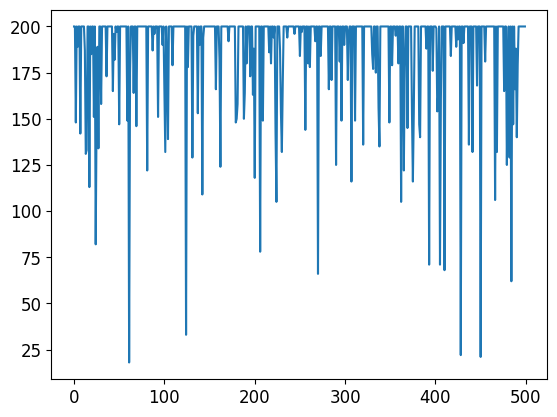

In [ ]:
print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))
plt.plot(totals)

- almost all cases, we have 200 rewards (still alive !)